In [1]:
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import os.path as op
from scipy.io import loadmat

import mne 

from mne import Epochs, pick_types, events_from_annotations
from mne.datasets import sample
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

from sklearn.preprocessing import scale

import mne_connectivity

from corrts import *

Creating RawArray with float64 data, n_channels=128, n_times=7677
    Range : 0 ... 7676 =      0.000 ...   119.938 secs
Ready.


/tmp/ipykernel_855656/3630929516.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sfreq = float(datafile["Fs"])


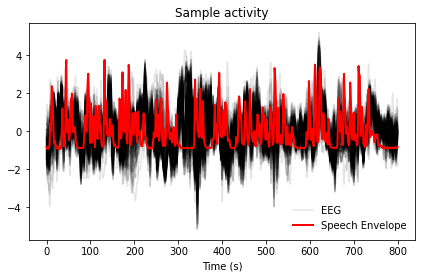

In [2]:
path = mne.datasets.mtrf.data_path()
decim = 2
datafile = loadmat(op.join(path, "speech_data.mat"))
raw = datafile["EEG"].T
speech = datafile["envelope"].T
sfreq = float(datafile["Fs"])
sfreq /= decim
speech = mne.filter.resample(speech, down=decim*2, npad="auto")
raw = mne.filter.resample(raw, down=decim, npad="auto")

# Read in channel positions and create our MNE objects from the raw data
montage = mne.channels.make_standard_montage("biosemi128")
info = mne.create_info(montage.ch_names, sfreq, "eeg").set_montage(montage)
raw = mne.io.RawArray(raw, info)
n_channels = len(raw.ch_names)

# Plot a sample of brain and stimulus activity
fig, ax = plt.subplots()
lns = ax.plot(scale(raw[:, :800][0].T), color="k", alpha=0.1)
ln1 = ax.plot(scale(speech[0, :800]), color="r", lw=2)
ax.legend([lns[0], ln1[0]], ["EEG", "Speech Envelope"], frameon=False)
ax.set(title="Sample activity", xlabel="Time (s)")
mne.viz.tight_layout()

In [3]:
data = raw.get_data()[None]

freq = np.linspace(1,20,20) 
rg   = 0.0005
Nc   = np.maximum(1, np.round(np.sqrt((2 * np.pi * freq / raw.info['sfreq'])**2 / (2*rg))))
Nc = 9
th_rg = (2 * np.pi * freq / raw.info['sfreq'])**2/ (2 * Nc**2)
print(Nc)
print(th_rg)

tfr  = mne.time_frequency.tfr_array_morlet(data, raw.info['sfreq'], freq, n_cycles=Nc, output='power', n_jobs=11, decim=2)
tfr  = np.sqrt(tfr)
tfr  = tfr[:, :, :, :2*(tfr.shape[-1] // 2)]

9
[5.94955898e-05 2.37982359e-04 5.35460308e-04 9.51929437e-04
 1.48738975e-03 2.14184123e-03 2.91528390e-03 3.80771775e-03
 4.81914277e-03 5.94955898e-03 7.19896637e-03 8.56736493e-03
 1.00547547e-02 1.16611356e-02 1.33865077e-02 1.52308710e-02
 1.71942255e-02 1.92765711e-02 2.14779079e-02 2.37982359e-02]


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   7 tasks      | elapsed:    0.9s
[Parallel(n_jobs=11)]: Done 105 tasks      | elapsed:    1.1s
[Parallel(n_jobs=11)]: Done 128 out of 128 | elapsed:    1.1s finished


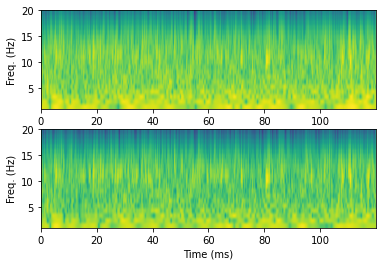

In [4]:
def plot_tfr(tfr, tvec, freq):
    extent = (tvec[0], tvec[-1], freq[0], freq[-1])
    
    plt.subplot(2,1,1)
    plt.imshow(tfr[0], aspect="auto", origin="lower", extent=extent)
    plt.xlabel('Time (ms)')
    plt.ylabel('Freq. (Hz)')
    
    plt.subplot(2,1,2)
    plt.imshow(tfr[2], aspect="auto", origin="lower", extent=extent)
    plt.xlabel('Time (ms)')
    plt.ylabel('Freq. (Hz)')
    
    
    plt.show()
    
plot_tfr(np.log(tfr[:].mean(0)), raw.times, freq);
# plot_tfr(np.log(tfr[ Ifeet].mean(0)), epochs.times, freq)

In [52]:
{k: _.mean() for k, _ in rgs.items()}, th_rgs

({'delta': 0.0008822158040167825,
  'theta': 0.006826625817370571,
  'alpha': 0.01849200368709945,
  'beta': 0.03409281561449775},
 {'delta': 6.941152143577344e-05,
  'theta': 0.00046852776969147076,
  'alpha': 0.0015171375399533336,
  'beta': 0.004127506542520099})

In [5]:
fbands = dict(
    delta = (freq[0], 4), 
    theta = (4, 8), 
    alpha = (8, 13),
    beta  = (13, 30), 
#     gamma = (30, freq[-1])
)

idxs = {k: np.where(np.logical_and(freq >= fmin, freq < fmax))[0]
       for k, (fmin, fmax) in fbands.items()}

pband = {k: tfr[:,:,idx].sum(2) for k, idx in idxs.items()} 
acfs  = {k: acf_welch(p) for k, p in pband.items()} 
rgs = {k: estimate_roughness(p, p) for k, p in pband.items()}
th_rgs = {k: th_rg[idx].mean() for k, idx in idxs.items()}


nlags = 50
for k, acf in acfs.items(): 
    
#     if k == 'delta': continue
        
    fig = go.Figure()
    
    rg = th_rgs[k]
        
    acf_recon = np.concatenate([acf[:,:,-nlags+1:],acf[:,:,:nlags+1]], axis=-1)
    lags      = np.arange(-nlags+1, nlags+1)
        
    n = acf.shape[-1]
    acf_sums  = acf[..., 0] + np.sum(2 * np.arange(n-1, 0, -1) * acf[...,1:n] **2, -1) / n
    acf_fit   = np.exp(-  lags[None, None, :]**2 * (rgs[k][:,:, None]) / 2 )
    
    print(f'{k}:\n' 
          f'    - sum of squares:     {acf_sums.mean():.2f} ({acf_sums.std():.2f})\n'
          f'    - known, theoretical: {np.sqrt(np.pi / (rg*4)):.2f}\n'
          f'    - knwon, sum of sq.:  {np.exp(- 4* lags**2 * (rg)  ).sum():.2f}\n'
          f'    - unkn., theoretical: {np.sqrt(2* np.pi/ rgs[k] ).mean():.2f}\n'
          f'    - unkn., sum of sq.:  {acf_fit.sum(-1).mean():.2f} ({acf_fit.sum(-1).std():.2f})\n')
#     plt.plot(lags, acf_recon**2)

    for i in range(acf.shape[0]):
        for j in range(acf.shape[1]):
            fig.add_scatter(x=lags, y=acf_recon[i,j]**2, showlegend=False, mode='lines', line_width=1, line_color='grey')
    
    fig.add_scatter(x=lags, y=acf_recon.mean((0,1))**2, showlegend=False, mode='lines', line_width=3, line_color='black')
    fig.add_scatter(x=lags, y=acf_fit.mean((0,1))**2, name='Gaussian fit',  showlegend=False, mode='lines', line_color='yellow', line_width=4, line_dash='dot')

    fig.add_scatter(x=lags, y=np.exp(- 2* lags**2 * (rg) ), name='Gaussian fit',  showlegend=False, mode='lines', line_color='red', line_width=4, line_dash='dash')
    fig.update_layout(template='simple_white', height=400, width=600)
    fig.show()

delta:
    - sum of squares:     42.89 (2.56)
    - known, theoretical: 53.19
    - knwon, sum of sq.:  52.20
    - unkn., theoretical: 45.86
    - unkn., sum of sq.:  45.52 (3.28)



theta:
    - sum of squares:     15.26 (0.83)
    - known, theoretical: 20.47
    - knwon, sum of sq.:  20.47
    - unkn., theoretical: 14.83
    - unkn., sum of sq.:  14.83 (0.57)



alpha:
    - sum of squares:     11.94 (1.75)
    - known, theoretical: 11.38
    - knwon, sum of sq.:  11.38
    - unkn., theoretical: 10.40
    - unkn., sum of sq.:  10.40 (1.14)



beta:
    - sum of squares:     8.24 (0.88)
    - known, theoretical: 6.90
    - knwon, sum of sq.:  6.90
    - unkn., theoretical: 7.69
    - unkn., sum of sq.:  7.69 (0.23)



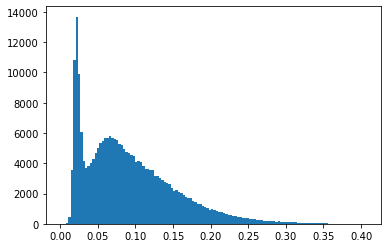

In [7]:
plt.hist(np.sqrt(datafile['spectrogram'].squeeze().flatten()), bins=128);

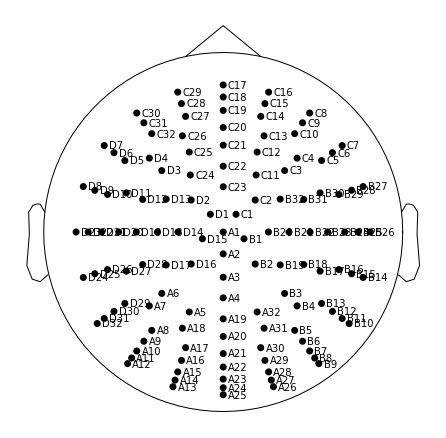

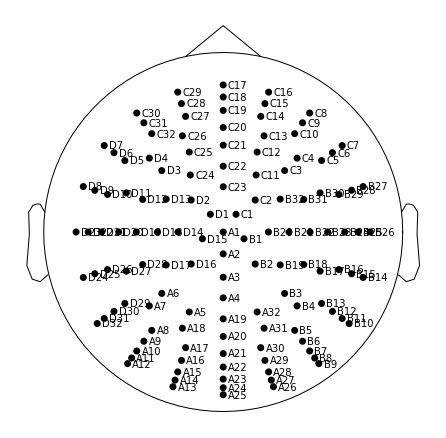

In [64]:
raw.plot_sensors(show_names=True)

In [49]:
eeg_speech_corr = spearman_r(tfr[0,:,:], speech)

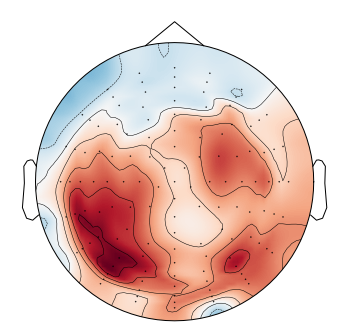

In [69]:
plt.rcParams['figure.figsize'] = (6,6)
mne.viz.plot_topomap(eeg_speech_corr.mean(1), raw.info, size=6); 

# for k, rs in pearson_rs.items():
#     mne.viz.plot_topomap(rs[0], raw.info, size=6)
#     plt.show()

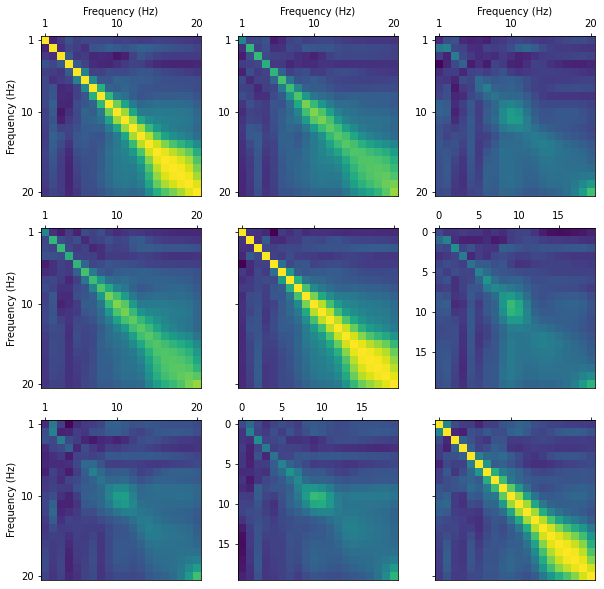

In [123]:
nc = 6
# ch_idx = np.argsort(np.abs(eeg_speech_corr).mean(1))[-nc//2:]
# ch_idx = np.concatenate([ch_idx, np.argsort(np.abs(eeg_speech_corr).mean(1))[:nc//2+1]])
# ch_names = [raw.ch_names[i] for i in ch_idx]

ch_names = ['D30', 'A18', 'B31']
nc = len(ch_names)
ch_idx = [raw.ch_names.index(ch) for ch in ch_names]

x = tfr[0, ch_idx, :, :] 

r = pearson_r(x[:, None, :, None], x[None, :, None, :])

vmin = r.min()
vmax = r.max()
f,axs = plt.subplots(nc,nc)
for i in range(nc):    
    plt.subplot(nc,nc,i+1 + i*nc)
#     plt.plot(freq, eeg_speech_corr[ch_idx[i]])
    
    plt.imshow(r[i,i], vmin=vmin, vmax=vmax)

#     plt.xticks([0, 9, 19], [1, 10, 20])
#     plt.yticks([0, 9, 19], [1, 10, 20])   
    
    axs[i, i].xaxis.set_ticks_position('top')   
    axs[i, i].xaxis.set_label_position('top')   
    plt.xticks([0, 9, 19], ['', '', ''])
    plt.yticks([0, 9, 19], ['', '', ''])
    
    if i == 0: 
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Frequency (Hz)')
        
        plt.xticks([0, 9, 19], [1, 10, 20])
        plt.yticks([0, 9, 19], [1, 10, 20])
        
    
    for j in range(nc):
        if j <= i: continue
            
        plt.subplot(nc,nc,j+1 + i*nc)
        plt.imshow(r[i,j], vmin=vmin, vmax=vmax)
        
        
        axs[i, j].xaxis.set_ticks_position('top')

#         plt.xticks([0, 9, 19], ['', '', ''])
#         plt.yticks([0, 9, 19], ['', '', ''])
        
        if i == 0: 
            axs[i, j].xaxis.set_label_position('top')   
            plt.xlabel('Frequency (Hz)')
            
            plt.xticks([0, 9, 19], [1, 10, 20])
            plt.yticks([0, 9, 19], [1, 10, 20])
            
        plt.subplot(nc,nc,i+1 + j*nc)
        plt.imshow(r[j,i], vmin=vmin, vmax=vmax)

#         plt.xticks([0, 9, 19], ['', '', ''])
#         plt.yticks([0, 9, 19], ['', '', ''])
        
        axs[j, i].xaxis.set_ticks_position('top')
        
        if i == 0: 
            plt.ylabel('Frequency (Hz)')
            plt.xticks([0, 9, 19], [1, 10, 20])
            plt.yticks([0, 9, 19], [1, 10, 20])
    
    
    
f.set_figheight(10)
f.set_figwidth(10)
plt.savefig('coupling.png')

In [14]:
x = tfr[0
pearson_r(x[None, :], x[:, None], axis=-1)

MemoryError: Unable to allocate 187. GiB for an array with shape (2560, 2560, 3838) and data type float64

In [63]:
pearson_rs  = {k: pearson_r(p, sqrt(speech[:, None, :])) for k, p in pband.items()}


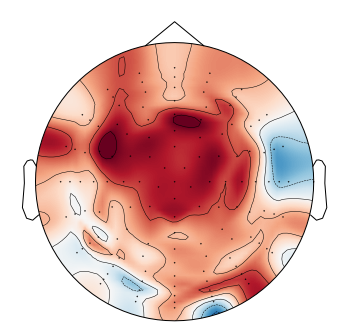

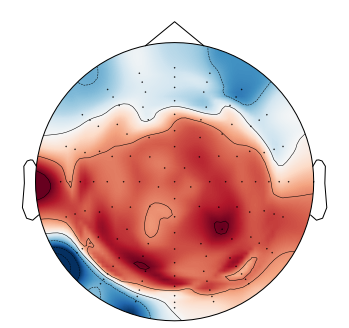

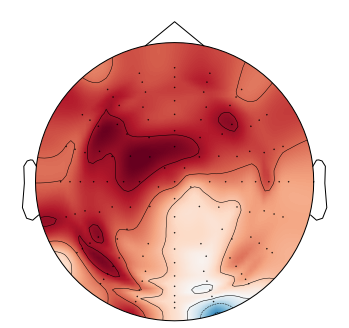

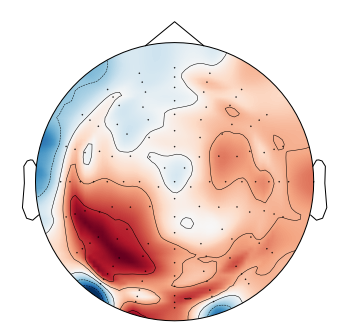

In [62]:
plt.rcParams['figure.figsize'] = (6,6)
for k, rs in pearson_rs.items():
    mne.viz.plot_topomap(rs[0], raw.info, size=6)
    plt.show()

In [16]:
pearson_stats  = {k: stats_summary(pearson_r,  p, speech[:, None, :], n_surrogates=1000) for k, p in pband.items()}
# spearman_stats = {k: stats_summary(spearman_r, p[:, 0], p[:, 1], n_surrogates=1000) for k, p in pband.items()}

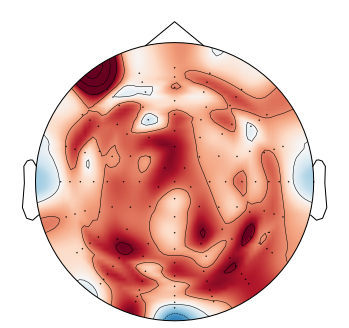

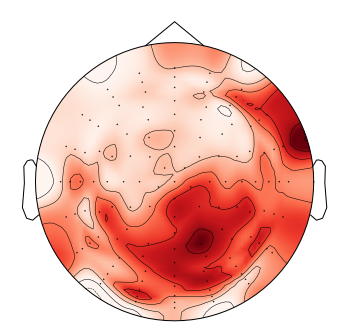

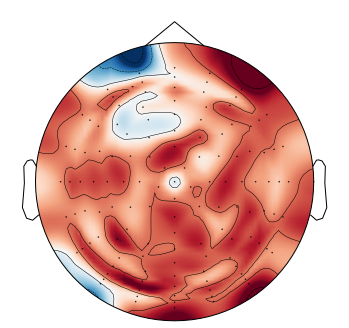

In [17]:
for k, rs in pearson_stats.items():
    mne.viz.plot_topomap(rs['p']['surrogates'][0]-rs['p']['rft'][0], raw.info, size=6)
    plt.show()

In [18]:
rs['p']['surrogates'][0] - 1.96 * np.sqrt(rs['p']['surrogates'][0] * (1-rs['p']['surrogates'][0]) / 1000)

array([0.82999067, 0.35779717, 0.35976895, 0.25605065, 0.12599067,
       0.08140581, 0.17520774, 0.07591227, 0.14671804, 0.20199648,
       0.18475477, 0.9009947 , 0.87924166, 0.70248311, 0.4930454 ,
       0.29499306, 0.12599067, 0.12786848, 0.21930627, 0.24441924,
       0.23281317, 0.52117773, 0.40923362, 0.34597782, 0.36174126,
       0.3637141 , 0.23088136, 0.22701998, 0.32632273, 0.39931489,
       0.3775388 , 0.46301191, 0.36766138, 0.40129762, 0.58788506,
       0.31847639, 0.18284349, 0.14482753, 0.20007727, 0.23281317,
       0.29499306, 0.13916318, 0.15050255, 0.22123355, 0.18666697,
       0.27354312, 0.31063923, 0.37951586, 0.39138909, 0.63472413,
       0.68599161, 0.45502183, 0.50308141, 0.59600982, 0.51715281,
       0.19049408, 0.31651623, 0.26187554, 0.24829361, 0.24635608,
       0.47501191, 0.54940893, 0.45102977, 0.42512991, 0.91861132,
       0.61839842, 0.30476747, 0.28913565, 0.32632273, 0.29303998,
       0.35779717, 0.48502555, 0.49505161, 0.42115281, 0.67365

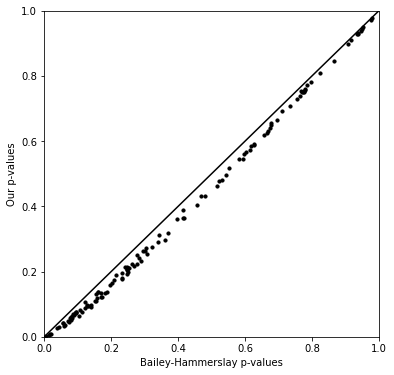

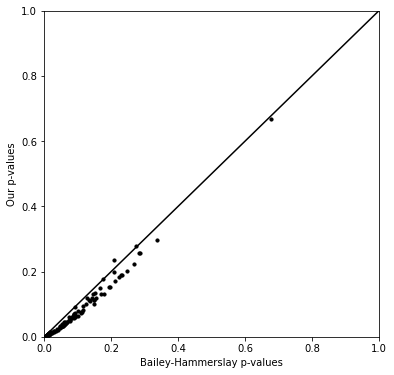

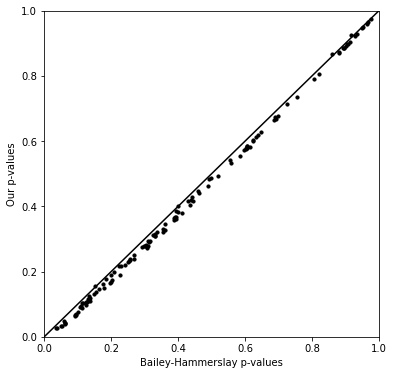

In [59]:
for k, rs in pearson_stats.items():

    r     = np.squeeze(rs['r'])
    ii    = np.argsort(r)
    psurr = rs['p']['bh'][0][ii]
    prft  = rs['p']['rft'][0][ii]

    nsurr = 1000
    ci95  = 1.96 * np.sqrt(psurr * (1-psurr) / nsurr)

    ci95x1 = psurr - ci95
    ci95x2 = psurr + ci95

    ci95x = np.concatenate([psurr - ci95, (psurr + ci95)[::-1]])
    ci95y = np.concatenate([prft, prft[::-1]])

#     plt.errorbar(psurr, prft, xerr=ci95, fmt='none', ecolor='r')
    plt.scatter(psurr, prft, s=10, c='k')
    plt.plot([-0,1],[-0,1],'k')
    plt.xlim([-0,1])
    plt.ylim([-0,1])
    plt.xlabel('Bailey-Hammerslay p-values')
    plt.ylabel('Our p-values')
    plt.show()

In [35]:
pband['alpha'].shape

(45, 3, 960)

 ...]

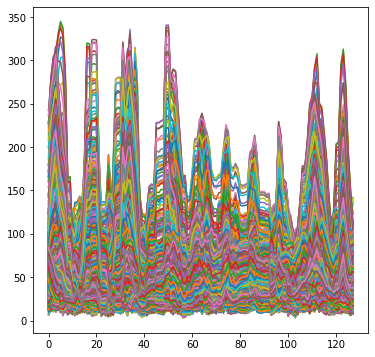

In [28]:
plt.plot(pband['alpha'][0])